# Customer segmentation

This notebook is focus on training models using PyTorch.

## 1. Data preparation

Algorithms for training need that the whole data is numeric, for that reason both categorical and target variables are going to be transformed into numeric values.

With respect to original numeric features need to be scaled.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
PATH_DATA = os.path.join(os.getenv("PATH_DATA_PROJECTS"), "Tabular", "customer_segmentation")

In [3]:
df_train = pd.read_csv(os.path.join(PATH_DATA, "train_cleaned.csv"))
print("Shape:", df_train.shape)
df_train.head()

Shape: (8068, 10)


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     8068 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        8068 non-null   object 
 4   Profession       8068 non-null   object 
 5   Work_Experience  8068 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      8068 non-null   float64
 8   Var_1            8068 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 630.4+ KB


### 1.1. Categorical

There are two types of categorical features:

* **Non ordinal**: all classes have the same meaning with respect to weight or position.
* **Ordinal**: the classes belong to a ranking where each class has weight.

#### 1.1.1. Non ordinal

These features are going to be transformed using OneHotEncoder.

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
categorical_features_n_ordinal = ["Gender", "Ever_Married", "Graduated", "Profession", "Var_1"]

In [7]:
# Get transformer instance
# sparse_output = False to return the values as vectors
# drop = first to remove first class, because the rest of classes are enough explanatory and reduce training time
onehot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

# Training
encoded_features_no_ordinal = onehot_encoder.fit_transform(df_train[categorical_features_n_ordinal])

# Turn result into a dataframe
df_one_hot_encoder = pd.DataFrame(encoded_features_no_ordinal, columns = onehot_encoder.get_feature_names_out())

#### 1.1.2. Ordinal

Each class is going to be encoded using a number.

In [8]:
def get_spending_score_encoded(spending_score):
    if spending_score == "Low":
        return 0
    elif spending_score == "Average":
        return 1
    elif spending_score == "High":
        return 2

In [9]:
df_train["Spending_Score"] = df_train["Spending_Score"].apply(get_spending_score_encoded)

### 1.2. Numeric

These features need to be scaled in order to improve performance. So, the encoder to be used is MinMaxScaler.

In [10]:
numeric_features = ["Age", "Work_Experience", "Family_Size"]

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()
ar = scaler.fit_transform(df_train[numeric_features])
df_numeric = pd.DataFrame(ar, columns = numeric_features)

for c in numeric_features:
    df_train[c] = df_numeric[c]

print("Shape:", df_train.shape)
df_train[numeric_features].describe()

Shape: (8068, 10)


,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,8068.000000
mean,0.358689,0.176641,0.232043
std,0.235376,0.233232,0.187447
min,0.000000,0.000000,0.000000
25%,0.169014,0.000000,0.125000
50%,0.309859,0.071429,0.250000
75%,0.492958,0.285714,0.375000
max,1.000000,1.000000,1.000000


### 1.3. Target variable

Each class is going to be encoded using a number.

In [13]:
target_variable = "Segmentation"

In [14]:
def get_segmentation_encoded(segmentation):
    if segmentation == "A":
        return 0
    elif segmentation == "B":
        return 1
    elif segmentation == "C":
        return 2
    else:
        return 3

In [15]:
df_train[target_variable] = df_train[target_variable].apply(get_segmentation_encoded)
df_train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,0.056338,No,Healthcare,0.071429,0,0.375,Cat_4,3
1,Female,Yes,0.281690,Yes,Engineer,0.071429,1,0.250,Cat_4,0
2,Female,Yes,0.690141,Yes,Engineer,0.071429,0,0.000,Cat_6,1
3,Male,Yes,0.690141,Yes,Lawyer,0.000000,2,0.125,Cat_6,1
4,Female,Yes,0.309859,Yes,Entertainment,0.071429,2,0.625,Cat_6,0


### 1.4. Get transformed dataset

Join all encoded features in order to create a dataset which is going to be used to feed training process.

In [16]:
df_train_encoded = pd.concat([df_train[numeric_features], df_one_hot_encoder, df_train[target_variable]], axis = 1)
print("Shape:", df_train_encoded.shape)
df_train_encoded.head()

Shape: (8068, 21)


,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,...,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
0,0.056338,0.071429,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
1,0.281690,0.071429,0.250,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.690141,0.071429,0.000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.690141,0.000000,0.125,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.309859,0.071429,0.625,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


## 2. Modeling

### 2.1. Split data into training and validation

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x = df_train_encoded.drop(target_variable, axis = 1).values
y = df_train_encoded[target_variable].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (6454, 20)
x_val shape: (1614, 20)
y_train shape: (6454,)
y_val shape: (1614,)


### 2.2. Training

This model is going to be created from scratch using a feedforward neural network.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

#### 2.2.1. Get metrics

In order to add more options to evaluate the performance of a model, the following metrics are going to be part of evaluation:

* Recall.
* Precision.
* F1 score.
* Accuracy.

In [21]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [22]:
def get_metrics(y_pred, y_true, average = "weighted", zero_division = 1):
    '''
        This function returns metrics for multiclass problem: Recall, Precision, F1 and Accuracy
    '''

    # Recall
    rec = recall_score(y_true, y_pred, average = average, zero_division = zero_division)

    # Precision
    pr = precision_score(y_true, y_pred, average = average, zero_division = zero_division)

    # F1
    f1 = f1_score(y_true, y_pred, average = average, zero_division = zero_division)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    return rec, pr, f1, acc

#### 2.2.2. Convert data to tensors and create data loader

In [23]:
batch_size = 64

# Convert numpy arrays to tensors (training data)
tensor_x_train = torch.tensor(x_train, dtype = torch.float32)
tensor_y_train = torch.tensor(y_train, dtype = torch.long)

# Convert numpy arrays to tensors (validation data)
tensor_x_val = torch.tensor(x_val, dtype = torch.float32)
tensor_y_val = torch.tensor(y_val, dtype = torch.long)

# Create datasets
train_ds_tensor = TensorDataset(tensor_x_train, tensor_y_train)
val_ds_tensor = TensorDataset(tensor_x_val, tensor_y_val)

# Create dataloaders to get data during training using batch
train_dataloader = DataLoader(train_ds_tensor, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_ds_tensor, batch_size = batch_size, shuffle = False)

#### 2.2.3. Create neural network (DNN)

In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)

        return out

#### 2.2.4. Define training and validation functions

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    '''
        Function to train neural network
    '''

    # total of batchs
    size = len(dataloader)
    train_loss = 0

    # Average loss result
    avg_train_loss = 0

    # Average recall result
    avg_train_rec = 0

    # Average precision result
    avg_train_pr = 0

    # Average F1-score result
    avg_train_f1 = 0

    # Average accuracy result
    avg_train_acc = 0

    # Accumulated recall result
    total_train_rec = 0

    # Accumulated precision result
    total_train_pr = 0

    # Accumulated F1-score result
    total_train_f1 = 0

    # Accumulated accuracy result
    total_train_acc = 0

    # Active training mode
    model.train()

    # Iterate over batches
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction error
        outputs = model(x)
        loss = loss_fn(outputs, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Getting wrong predictions
        train_loss += loss.item()

        # Calculating sklearn metrics
        _, pred = torch.max(outputs.data, 1)
        rec, pr, f1, acc = get_metrics(pred.numpy(), y)

        # Acumulate metric values
        total_train_rec += rec
        total_train_pr += pr
        total_train_f1 += f1
        total_train_acc += acc

    # Get average about metrics and loss
    avg_train_loss = train_loss / size
    avg_train_rec = total_train_rec / size
    avg_train_pr = total_train_pr / size
    avg_train_f1 = total_train_f1 / size
    avg_train_acc = total_train_acc / size

    print(f"Training loss: {avg_train_loss:>7f}")

    return avg_train_loss, avg_train_rec, avg_train_pr, avg_train_f1, avg_train_acc

In [26]:
def val(dataloader, model, loss_fn):
    '''
        Function to validate neural network
    '''
    size = len(dataloader)

    predictions = []
    true_values = []

    # Active evaluation mode
    model.eval()
    val_loss = 0
    correct = 0

    # Average loss result
    avg_val_loss = 0

    # Average recall result
    avg_val_rec = 0

    # Average precision result
    avg_val_pr = 0

    # Average F1-Score result
    avg_val_f1 = 0

    # Average accuracy result
    avg_val_acc = 0


    # Accumulated recall result
    total_val_rec = 0

    # Accumulated precision result
    total_val_pr = 0

    # Accumulated F1-Score result
    total_val_f1 = 0

    # Accumulated accuracy result
    total_val_acc = 0

    with torch.no_grad():
        for x, y in dataloader:
            outputs = model(x)

            # Getting wrong predictions
            val_loss += loss_fn(outputs, y).item()

            # Calculating sklearn metrics
            _, pred = torch.max(outputs.data, 1)
            rec, pr, f1, acc = get_metrics(pred.numpy(), y)

            # Acumulate metric values
            total_val_rec += rec
            total_val_pr += pr
            total_val_f1 += f1
            total_val_acc += acc

        avg_val_loss = val_loss / size
        avg_val_rec = total_val_rec / size
        avg_val_pr = total_val_pr / size
        avg_val_f1 = total_val_f1 / size
        avg_val_acc = total_val_acc / size

        print(f"Test Error: \n Avg accuracy: {(avg_val_acc):>0.4f}, \n Avg recall: {(avg_val_rec):>0.4f}, \n Avg precision: {(avg_val_pr):>0.4f}, \n Avg F1: {(avg_val_f1):>0.4f}, \n Avg loss: {avg_val_loss:>8f} \n")

    return avg_val_loss, avg_val_rec, avg_val_pr, avg_val_f1, avg_val_acc

In [27]:
def train_run(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs = 10, early_stopping = False, monitor = 'loss', patience = 3):
    '''
        Function to run training and validation process
    '''

    epochs_list = []
    train_losses = []
    acc_train_scores = []
    rec_train_scores = []
    pre_train_scores = []
    f1_train_scores = []

    val_losses = []
    acc_val_scores = []
    rec_val_scores = []
    pre_val_scores = []
    f1_val_scores = []

    train_metrics = { "epochs": epochs_list, "loss": train_losses, "accuracy": acc_train_scores, "recall": rec_train_scores, "precision": pre_train_scores, "f1": f1_train_scores }
    val_metrics = { "epochs": epochs_list, "loss": val_losses, "accuracy": acc_val_scores, "recall": rec_val_scores, "precision": pre_val_scores, "f1": f1_val_scores }

    # Early stopping parameters
    min_val_monitor = float("inf")
    max_val_monitor = 0
    epochs_without_improvement = 0
    best_model_weights = None
    val_monitor = 0

    monitor = monitor.lower()
    if early_stopping:
        print("Early stopping enable using validation monitor:", monitor)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")

        train_loss, train_rec, train_pr, train_f1, train_acc = train(train_dataloader, model, loss_fn, optimizer)
        val_loss, val_rec, val_pr, val_f1, val_acc = val(val_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        acc_train_scores.append(train_acc)
        rec_train_scores.append(train_rec)
        pre_train_scores.append(train_pr)
        f1_train_scores.append(train_f1)

        val_losses.append(val_loss)
        acc_val_scores.append(val_acc)
        rec_val_scores.append(val_rec)
        pre_val_scores.append(val_pr)
        f1_val_scores.append(val_f1)

        epochs_list.append(t+1)

        if early_stopping:
            if monitor == "accuracy":
                val_monitor = val_acc
            elif monitor == "recall":
                val_monitor = val_rec
            elif monitor == "precision":
                val_monitor = val_pr
            elif monitor == "f1":
                val_monitor = val_f1
            else:
                val_monitor = val_loss

            # Check for improvement
            if monitor == "loss":
                if val_monitor < min_val_monitor:
                    epochs_without_improvement = 0
                    min_val_monitor = val_monitor
                    best_model_weights = model.state_dict()
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= patience:
                        print(f"Early stopping after {t+1} epochs")
                        break
            else:
                if val_monitor > max_val_monitor:
                    epochs_without_improvement = 0
                    max_val_monitor = val_monitor
                    best_model_weights = model.state_dict()
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= patience:
                        print(f"Early stopping after {t+1} epochs")
                        break

    print("Done!")
    return train_metrics, val_metrics

#### 2.2.5. Perform training

In [28]:
input_size = x.shape[1]
num_classes = len(np.unique(y))

# Instance model
model = NeuralNetwork(input_size, num_classes)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=4, bias=True)
)


In [29]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer funtion
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [30]:
train_metrics = {}
val_metrics = {}
epochs = 100

# Perform training
train_metrics, val_metrics = train_run(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs = epochs, early_stopping = True, monitor = "f1")

Early stopping enable using validation monitor: f1
Epoch 1
-------------------------------
Training loss: 1.385284
Test Error: 
 Avg accuracy: 0.2934, 
 Avg recall: 0.2934, 
 Avg precision: 0.7946, 
 Avg F1: 0.1349, 
 Avg loss: 1.383002 

Epoch 2
-------------------------------
Training loss: 1.385114
Test Error: 
 Avg accuracy: 0.2934, 
 Avg recall: 0.2934, 
 Avg precision: 0.7946, 
 Avg F1: 0.1349, 
 Avg loss: 1.382842 

Epoch 3
-------------------------------
Training loss: 1.384940
Test Error: 
 Avg accuracy: 0.2934, 
 Avg recall: 0.2934, 
 Avg precision: 0.7946, 
 Avg F1: 0.1349, 
 Avg loss: 1.382693 

Epoch 4
-------------------------------
Training loss: 1.384790
Test Error: 
 Avg accuracy: 0.2934, 
 Avg recall: 0.2934, 
 Avg precision: 0.7946, 
 Avg F1: 0.1349, 
 Avg loss: 1.382548 

Early stopping after 4 epochs
Done!


#### 2.2.6. Metrics

Training metric results

In [31]:
pd.DataFrame(train_metrics)

,epochs,loss,accuracy,recall,precision,f1
0,1,1.385284,0.277938,0.277938,0.802264,0.123761
1,2,1.385114,0.278053,0.278053,0.801786,0.123430
2,3,1.384940,0.277852,0.277852,0.802098,0.123404
3,4,1.384790,0.277910,0.277910,0.801812,0.123291


Validation metric results

In [32]:
pd.DataFrame(val_metrics)

,epochs,loss,accuracy,recall,precision,f1
0,1,1.383002,0.293441,0.293441,0.794566,0.134896
1,2,1.382842,0.293441,0.293441,0.794566,0.134896
2,3,1.382693,0.293441,0.293441,0.794566,0.134896
3,4,1.382548,0.293441,0.293441,0.794566,0.134896


#### 2.2.7. Plot

##### 2.2.7.1. Loss

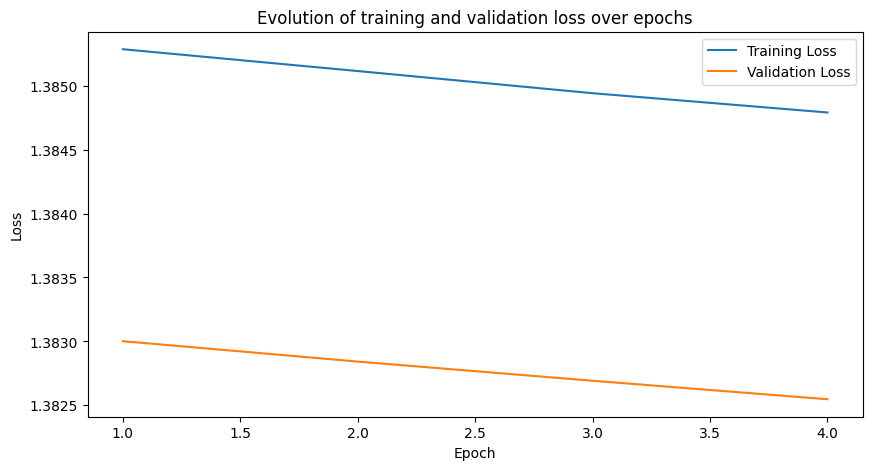

In [33]:
epochs = range(1, len(train_metrics["epochs"]) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_metrics["loss"], label = "Training Loss")
plt.plot(epochs, val_metrics["loss"], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Evolution of training and validation loss over epochs")
plt.show()

##### 2.2.7.2. Classification metric

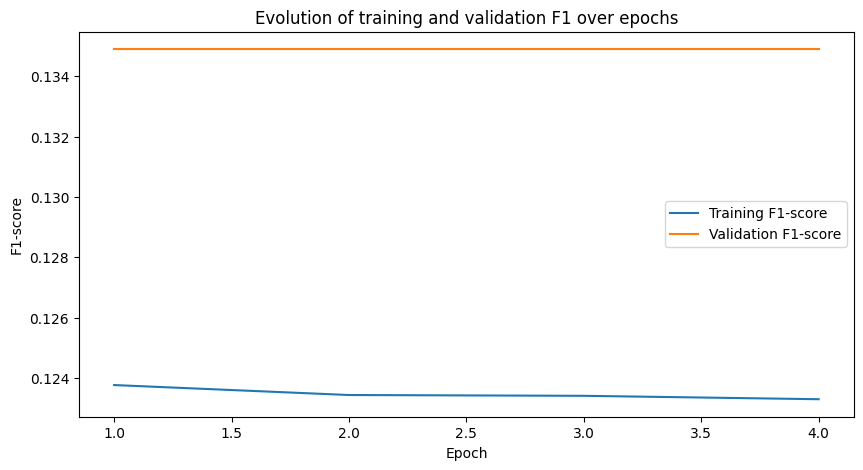

In [34]:
epochs = range(1, len(train_metrics["epochs"]) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_metrics["f1"], label = "Training F1-score")
plt.plot(epochs, val_metrics["f1"], label = "Validation F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.legend()
plt.title("Evolution of training and validation F1 over epochs")
plt.show()

### 2.3. Evaluation

In [35]:
df_test = pd.read_csv(os.path.join(PATH_DATA, "test_cleaned.csv"))
print("Shape:", df_test.shape)
df_test.head()

Shape: (2627, 9)


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,Female,Yes,69,No,Artist,0.0,Low,1.0,Cat_6
3,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,Female,No,19,No,Marketing,1.0,Low,4.0,Cat_6


In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           2627 non-null   object 
 1   Ever_Married     2627 non-null   object 
 2   Age              2627 non-null   int64  
 3   Graduated        2627 non-null   object 
 4   Profession       2627 non-null   object 
 5   Work_Experience  2627 non-null   float64
 6   Spending_Score   2627 non-null   object 
 7   Family_Size      2627 non-null   float64
 8   Var_1            2627 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 184.8+ KB
